In [1]:
import os
os.chdir('..')
import datetime

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import backtrader as bt
import plotly.express as px
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from scipy import poly1d, stats
import sklearn.preprocessing as pre
from statsmodels.tsa.stattools import coint
import pandas_datareader.data as web

In [3]:
from trackingfilters.kalman import LinKalmanFilter as lkf

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
# sp500 = pd.read_csv("datasets/sp500_modified.csv").drop(['Unnamed: 0'], axis=1).set_index('DATE')

In [6]:
# bank_df = sp500.loc[:, ['WFC', 'JPM']]

In [7]:
jpm = pd.read_csv('datasets/JPM.csv')
wfc = pd.read_csv('datasets/WFC.csv')

In [8]:
bank_df = pd.merge(jpm[['Date', 'Close']], wfc[['Date','Close']], on=['Date'], how='inner', suffixes=('_J', '_W')).rename({'Close_J': 'JPM', 'Close_W': 'WFC'}, axis=1)

In [9]:
bank_return = bank_df.set_index('Date').pct_change().dropna(how='any')

In [10]:
x = bank_df['JPM']
y = bank_df['WFC']

x_ret = bank_return['JPM']
y_ret = bank_return['WFC']

### Applying on a Price Series

In [11]:
delta = 0.001
init_state_vec = np.zeros(2).reshape(-1,1)
init_state_cov_mat = np.ones((2,2))
process_noise_mat = delta/(1-delta) * np.eye(2)
transition_mat = np.eye(2)
control_mat = np.array([0, 0]).reshape(-1,1)
control_vec = np.array([0]).reshape(-1,1)
measure_noise_mat = np.array([0.25]).reshape(-1,1)
observation_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)

In [12]:
price_weighter = lkf(init_state_vec=init_state_vec, 
                    init_state_cov_mat = init_state_cov_mat,
                    transition_mat=transition_mat,
                    observation_mat=observation_mat,
                    control_vec=control_vec,
                    control_mat=control_mat,
                    process_noise_mat=process_noise_mat,
                    measure_noise_mat=measure_noise_mat)

In [13]:
price_weighter.vec_update(y)

In [14]:
price_vec, price_cov, price_kalman = price_weighter.agg_result()

In [15]:
kalman_df = pd.DataFrame(price_vec[1:, :2, 0], columns=['SLOPE', 'INTERCEPT'], index=x.index)

### Applying on a Return Series

In [16]:
np.cov(x_ret, y_ret)[0][1]

0.000309720643869349

In [17]:
delta = 0.001
init_state_vec = np.zeros(2).reshape(-1,1)
init_state_cov_mat = np.ones((2,2))
process_noise_mat = delta/(1-delta) * np.eye(2)
transition_mat = np.eye(2)
control_mat = np.array([0, 0]).reshape(-1,1)
control_vec = np.array([0]).reshape(-1,1)
measure_noise_mat = np.array([np.cov(x_ret, y_ret)[0][1]]).reshape(-1,1)
observation_mat = np.expand_dims(np.vstack([[x_ret], [np.ones(len(x_ret))]]).T, axis=1)

return_weighter = lkf(init_state_vec=init_state_vec, 
                    init_state_cov_mat = init_state_cov_mat,
                    transition_mat=transition_mat,
                    observation_mat=observation_mat,
                    control_vec=control_vec,
                    control_mat=control_mat,
                    process_noise_mat=process_noise_mat,
                    measure_noise_mat=measure_noise_mat)

return_weighter.vec_update(y_ret)
return_vec, return_cov, return_kalman = return_weighter.agg_result()

In [18]:
kalman_ret_df = pd.DataFrame(return_vec[1:, :2, 0], columns=['SLOPE', 'INTERCEPT'], index=bank_return.index)

C:\Users\songq\AppData\Local\Continuum\anaconda3\envs\analysis_env\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



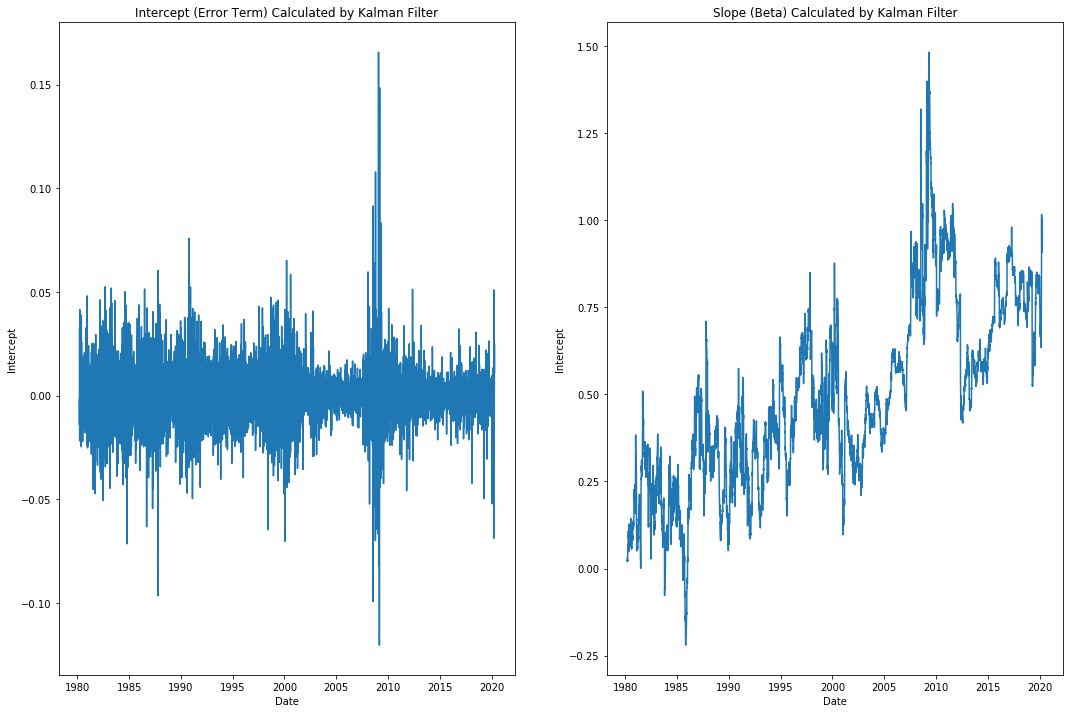

In [19]:
fig, ax = plt.subplots(1,2, figsize=(18, 12))

first_fig = sns.lineplot(x=pd.to_datetime(kalman_ret_df.index), y='INTERCEPT', data=kalman_ret_df, ax=ax[0]);
first_fig.set(xlabel="Date",
       ylabel="Intercept",
       title=f'Intercept (Error Term) Calculated by Kalman Filter');

sec_fig = sns.lineplot(x=pd.to_datetime(kalman_ret_df.index), y='SLOPE', data=kalman_ret_df, ax=ax[1]);
sec_fig.set(xlabel="Date",
       ylabel="Intercept",
       title=f'Slope (Beta) Calculated by Kalman Filter');

date_form = DateFormatter("%Y");
ax[0].xaxis.set_major_formatter(date_form);
ax[1].xaxis.set_major_formatter(date_form);

plt.show()

### Linear Model
- Beta is a time-varying factor that changes significantly through time
- Therefore using Kalman Filter can help capture the change

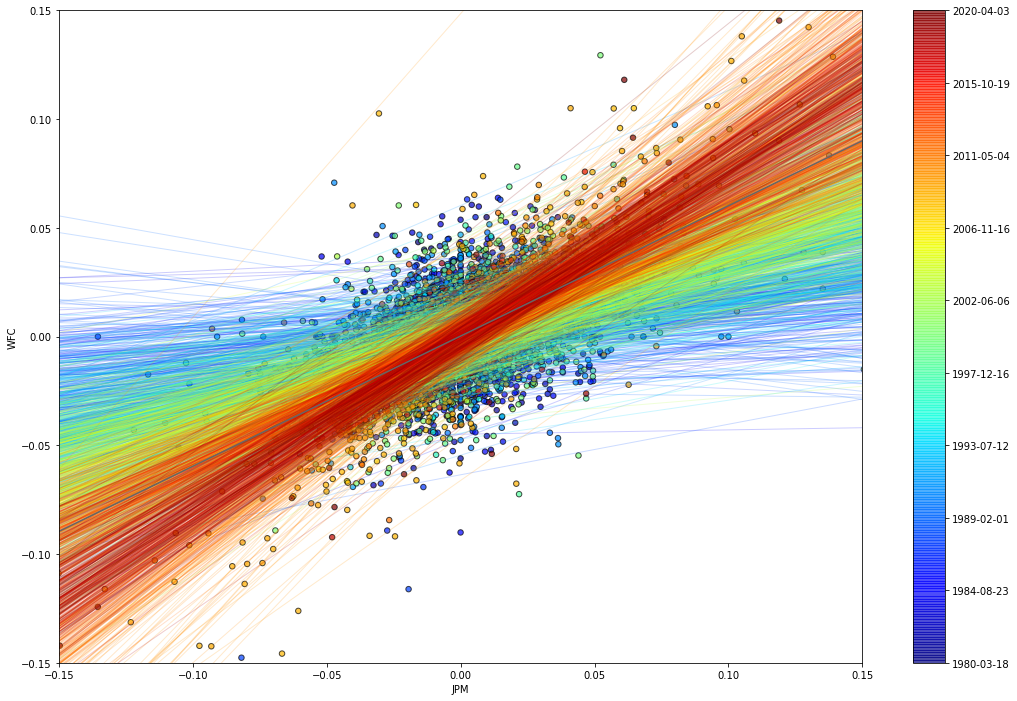

In [20]:
fig, ax = plt.subplots(figsize=(18, 12))
# Plot data points using colormap
cm = plt.get_cmap('jet');
colors = np.linspace(0.1, 1, len(x_ret));

sc = plt.scatter(x_ret, y_ret, s=30, c=colors, cmap=cm, edgecolor='k', alpha=0.7);
cb = plt.colorbar(sc);
cb.ax.set_yticklabels([str(p) for p in x_ret[::len(x_ret)//9].index]);

# Plot every fifth line
step = 5
xi = np.linspace(x_ret.min()-5, x_ret.max()+5, 2)
colors_l = np.linspace(0.1, 1, len(kalman_ret_df[::step]))
for i, beta in enumerate(kalman_ret_df.values[::step]):
    plt.plot(xi, beta[0] * xi + beta[1], alpha=.2, lw=1, c=cm(colors_l[i]));
    
# Plot the OLS regression line
plt.plot(xi, poly1d(np.polyfit(x_ret, y_ret, 1))(xi), '0.4');

# Adjust axes for visibility
plt.axis([-0.15, 0.15, -0.15, 0.15]);

# Label axes
plt.xlabel('JPM');
plt.ylabel('WFC');
plt.show()

### Kalman State Estimate VS Measurement
- Compare the measured return of JPM versus the state estimation by Kalman

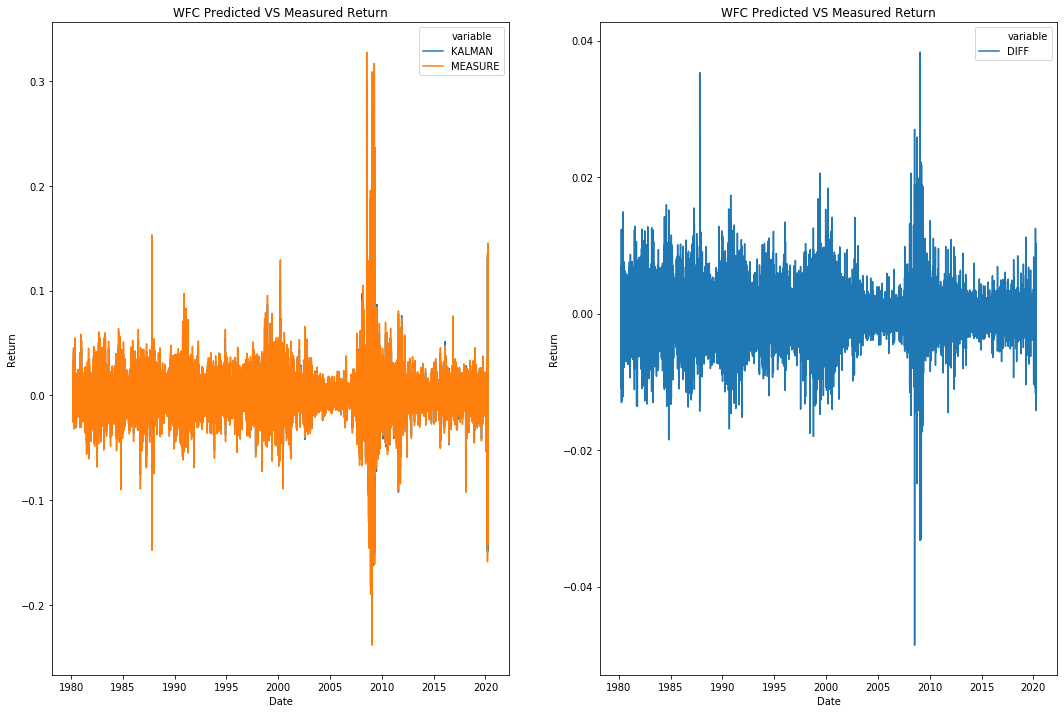

In [21]:
fig, ax = plt.subplots(1,2, figsize=(18,12));

temp_df = pd.DataFrame(columns=['KALMAN', 'MEASURE'], index=bank_return.index)
temp_df['KALMAN'] = kalman_ret_df['SLOPE'] * x_ret + kalman_ret_df['INTERCEPT']
temp_df['MEASURE'] = y_ret
temp_df['DIFF'] = temp_df['MEASURE'] - temp_df['KALMAN']
temp_df = temp_df.reset_index()
temp_df['DATE'] = pd.to_datetime(temp_df['Date'])


first_fig = sns.lineplot(
    data=pd.melt(
    temp_df,
    id_vars='DATE', value_vars=['KALMAN', 'MEASURE']),
    x='DATE',
    y='value',
    hue='variable', ax=ax[0]);

first_fig.set(xlabel="Date",
       ylabel="Return",
       title=f"WFC Predicted VS Measured Return");


sec_fig = sns.lineplot(
    data=pd.melt(
    temp_df,
    id_vars='DATE', value_vars=['DIFF']),
    x='DATE',
    y='value',
    hue='variable', ax=ax[1]);

sec_fig.set(xlabel="Date",
       ylabel="Return",
       title=f"WFC Predicted VS Measured Return");

date_form = DateFormatter("%Y");
ax[0].xaxis.set_major_formatter(date_form);
ax[1].xaxis.set_major_formatter(date_form);

### Normalize Error

In [22]:
kalman_ret_df['STD_ERR'] = stats.zscore(kalman_ret_df['INTERCEPT'])

### Backtesting Strategy that trades based on Z-score determined by Kalman Filter, Rolling Regression & Something Else (Move to Pair Trading Repo)

In [124]:
class KalmanMovingAverage(bt.indicators.MovingAverageBase):
    packages = ('pykalman',)
    frompackages = (('pykalman', [('KalmanFilter', 'KF')]),)
    lines = ('kma',)
    alias = ('KMA',)
    params = (
        ('initial_state_covariance', 1.0),
        ('observation_covariance', 1.0),
        ('transition_covariance', 0.05),
    )

    def __init__(self):
        self.addminperiod(self.p.period)  # when to deliver values
        self._dlast = self.data(-1)  # get previous day value

    def nextstart(self):
        self._k1 = self._dlast[0]
        self._c1 = self.p.initial_state_covariance

        self._kf = pykalman.KalmanFilter(
            transition_matrices=[1],
            observation_matrices=[1],
            observation_covariance=self.p.observation_covariance,
            transition_covariance=self.p.transition_covariance,
            initial_state_mean=self._k1,
            initial_state_covariance=self._c1,
        )

        self.next()

    def next(self):
        k1, self._c1 = self._kf.filter_update(self._k1, self._c1, self.data[0])
        self.lines.kma[0] = self._k1 = k1
        print(k1, 'k1')
        print(self._c1, 'c1')


class NumPy(object):
    packages = (('numpy', 'np'),)


class KalmanFilterInd(bt.Indicator, NumPy):
    _mindatas = 2  # needs at least 2 data feeds

    packages = ('pandas',)
    lines = ('et', 'sqrt_qt')

    params = dict(
        delta=1e-4,
        vt=1e-3,
    )

    def __init__(self):
        self.wt = self.p.delta / (1 - self.p.delta) * np.eye(2)
        self.theta = np.zeros(2)
        self.R = None

        self.d1_prev = self.data1(-1)  # data1 yesterday's price

    def next(self):
        F = np.asarray([self.data0[0], 1.0]).reshape((1, 2))
        y = self.d1_prev[0]

        if self.R is not None:  # self.R starts as None, self.C set below
            self.R = self.C + self.wt
        else:
            self.R = np.zeros((2, 2))

        yhat = F.dot(self.theta)
        et = y - yhat

        # Q_t is the variance of the prediction of observations and hence
        # \sqrt{Q_t} is the standard deviation of the predictions
        Qt = F.dot(self.R).dot(F.T) + self.p.vt
        sqrt_Qt = np.sqrt(Qt)

        # The posterior value of the states \theta_t is distributed as a
        # multivariate Gaussian with mean m_t and variance-covariance C_t
        At = self.R.dot(F.T) / Qt
        self.theta = self.theta + At.flatten() * et
        self.C = self.R - At * F.dot(self.R)

        # Fill the lines
        self.lines.et[0] = et
        self.lines.sqrt_qt[0] = sqrt_Qt


class KalmanSignals(bt.Indicator):
    _mindatas = 2  # needs at least 2 data feeds

    lines = ('long', 'short',)

    def __init__(self):
        kf = KalmanFilterInd()
        et, sqrt_qt = kf.lines.et, kf.lines.sqrt_qt
        
        print(et, sqrt_qt, 'et, qt')

        self.lines.long = et < -1.0 * sqrt_qt
        # longexit is et > -1.0 * sqrt_qt ... the opposite of long
        self.lines.short = et > sqrt_qt
        # shortexit is et < sqrt_qt ... the opposite of short


class KalmanSt(bt.Strategy):
    params = dict(
        ksigs=False,  # attempt trading
        period=30,
    )

    def __init__(self):
        if self.p.ksigs:
            self.ksig = KalmanSignals()
#             KalmanFilter()

        KalmanMovingAverage(period=self.p.period)
        bt.ind.SMA(period=self.p.period)
        if True:
            kf = KalmanFilterInd()
            kf.plotlines.sqrt_qt._plotskip = True

    def next(self):
        if not self.p.ksigs:
            return

        size = self.position.size
        if not size:
            if self.ksig.long:
                self.buy()
            elif self.ksig.short:
                self.sell()

        elif size > 0:
            if not self.ksig.long:
                self.close()
        elif not self.ksig.short:  # implicit size < 0
            self.close()

In [125]:
cerebro = bt.Cerebro()
cerebro.broker.setcash(100000.0)

In [126]:
datalist = [
    ('datasets/JPM.csv', 'JPM'),
    ('datasets/WFC.csv', 'WFC'),
]

for i in range(len(datalist)):
    data = bt.feeds.YahooFinanceCSVData(dataname=datalist[i][0], fromdate=datetime.datetime(1981,1,1), todate=datetime.datetime(2020,1,1))
    cerebro.adddata(data, name=datalist[i][1])

In [127]:
cerebro.addstrategy(KalmanSt)

0

In [129]:
cerebro.run??

<IPython.core.display.Javascript object>


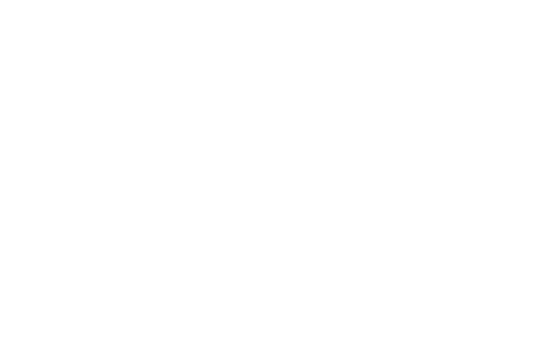

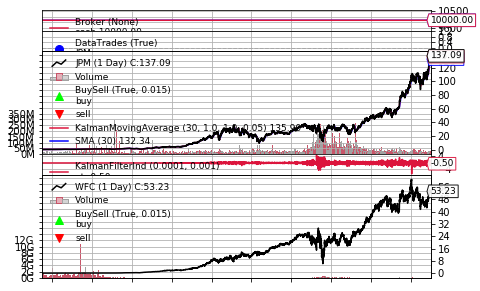

In [108]:
cerebro.plot();
plt.show()